In [73]:
%pip install xgboost --quiet

Note: you may need to restart the kernel to use updated packages.


In [74]:
#Imports & settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (precision_score, recall_score, f1_score,
                             accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)

import joblib
RANDOM_STATE = 42
sns.set(style='whitegrid')


In [75]:
#Load dataset & basic EDA
DATA_PATH = "diabetes.csv"
df = pd.read_csv(DATA_PATH)

# Quick checks
print("Shape:", df.shape)
display(df.head())
print("\nInfo:")
display(df.info())
print("\nDescriptive stats:")
display(df.describe())

# Class balance
print("\nOutcome value counts:")
display(df['Outcome'].value_counts())


Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None


Descriptive stats:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Outcome value counts:


Outcome
0    500
1    268
Name: count, dtype: int64

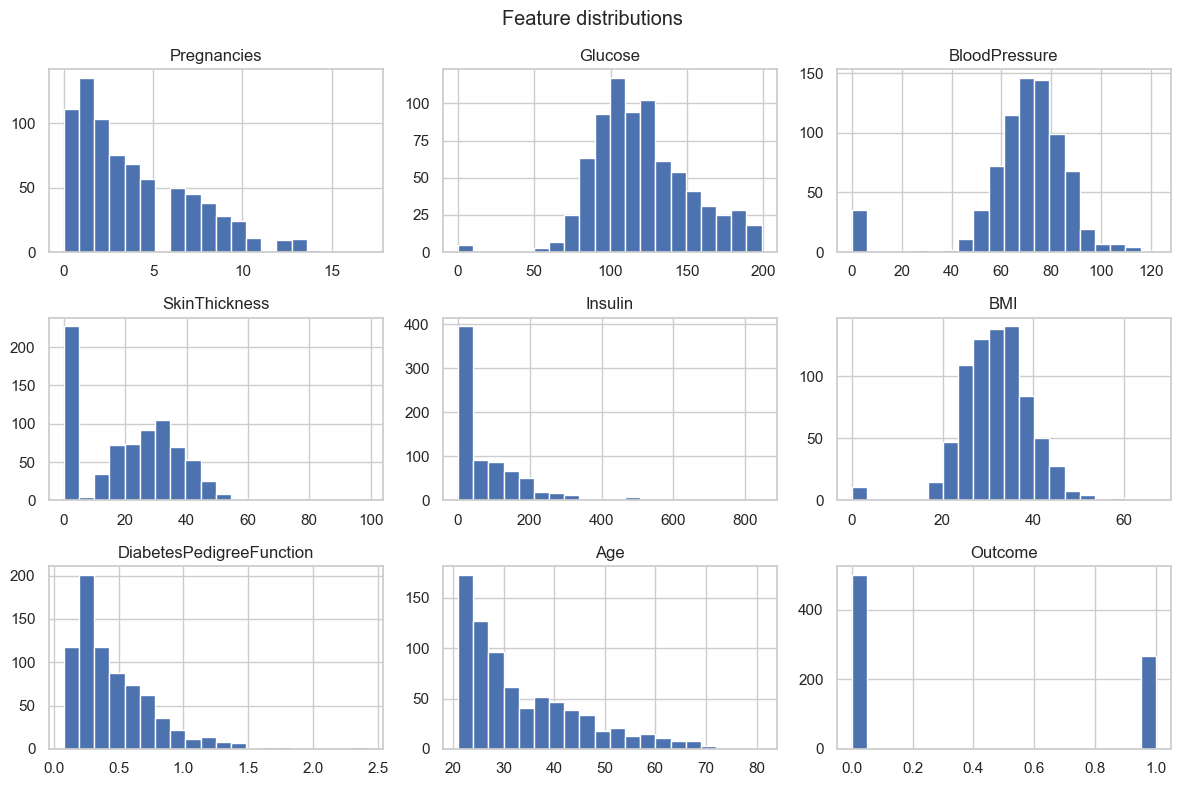

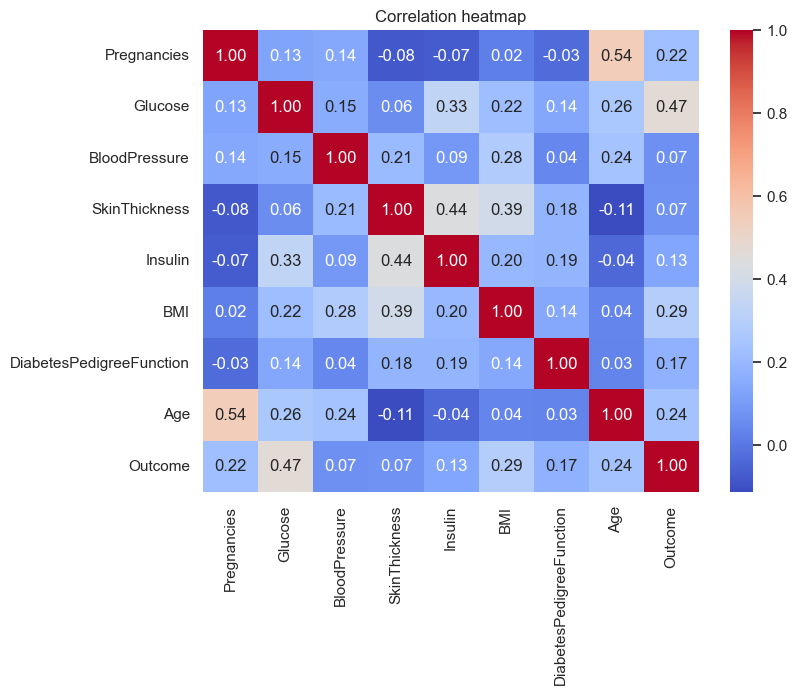

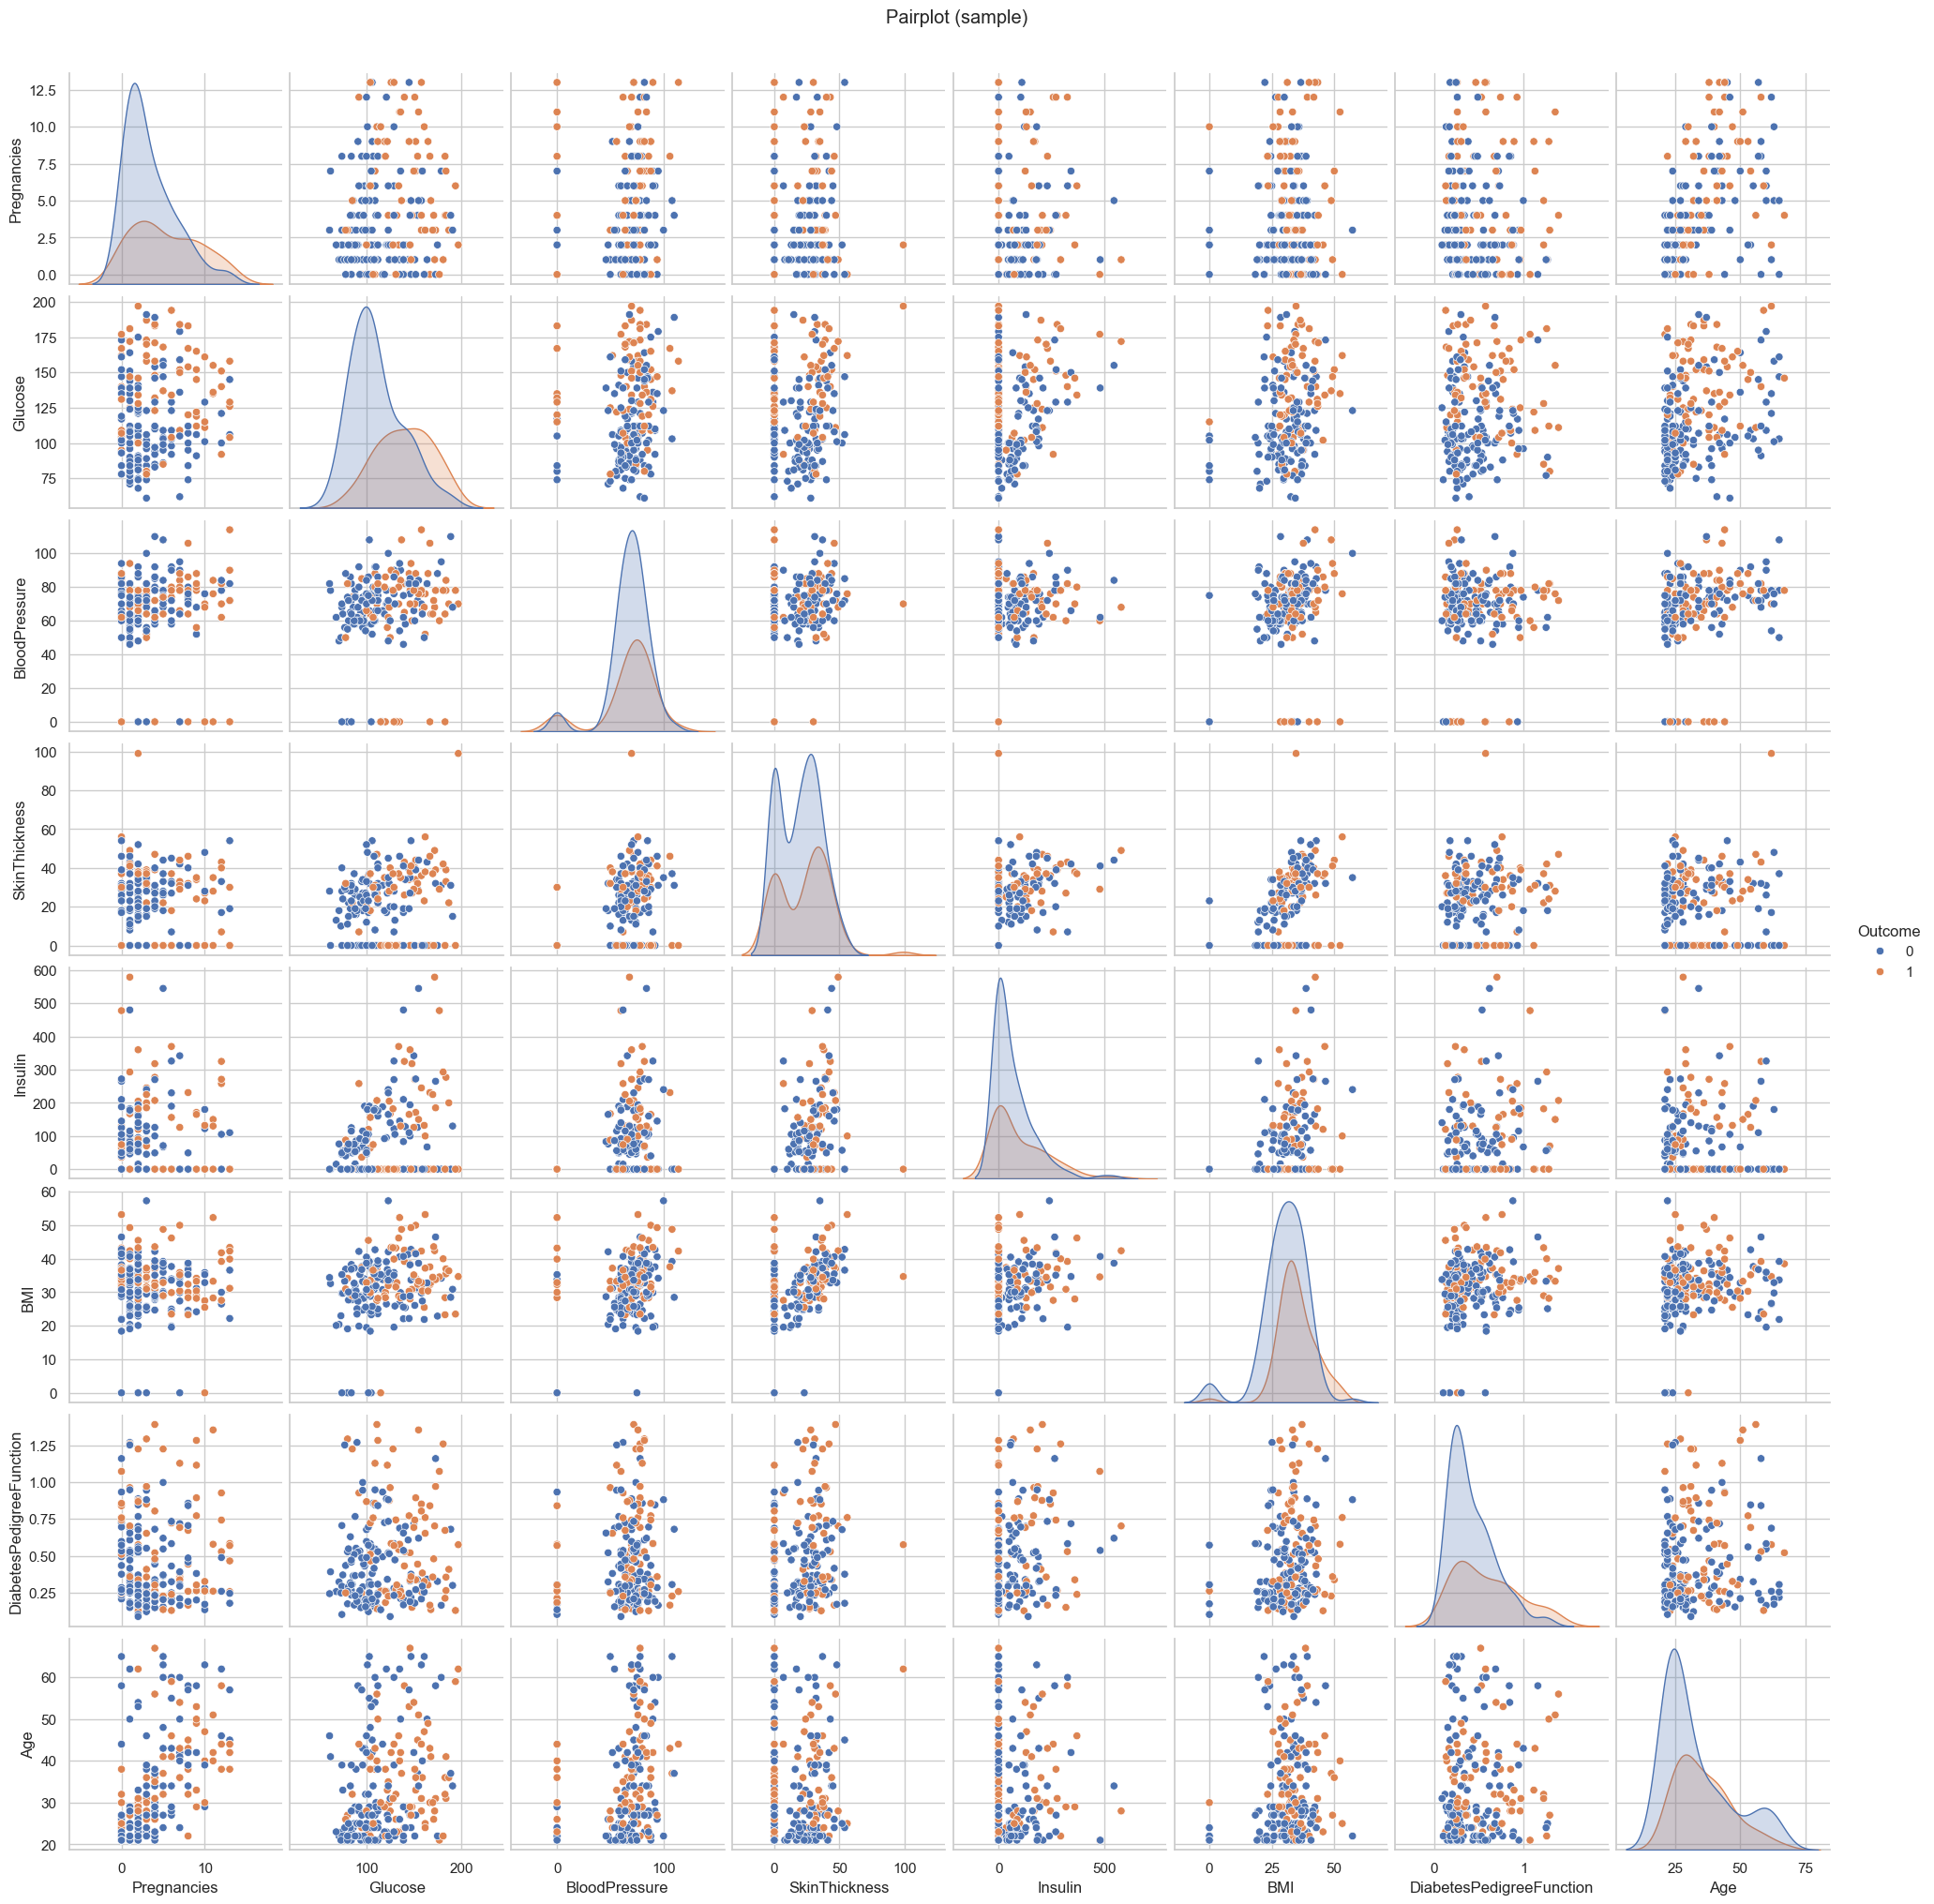

In [76]:
# ===========================
# Cell 4 — Visualizations (histograms, correlation, pairplot sample)
# ===========================
# Histograms
df.hist(figsize=(12,8), bins=20)
plt.suptitle("Feature distributions")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation heatmap")
plt.show()

# Pairplot — use a sample to speed up rendering
sample = df.sample(n=200, random_state=RANDOM_STATE) if len(df)>200 else df
sns.pairplot(sample, hue='Outcome', vars=df.columns.drop('Outcome'))
plt.suptitle("Pairplot (sample)", y=1.02)
plt.show()


In [77]:
# ===========================
# Cell 5 — Preprocessing (replace zeros for certain cols -> median)
# ===========================
# BEFORE splitting: convert zeros that indicate missing to NaN
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Quick check: show missing % per col (helps decide if some columns are too sparse)
missing_pct = df[cols_with_zero].isna().mean() * 100
print("Missing percentage (cols):\n", missing_pct)

# Count zeros before
print("Zero counts BEFORE replacement:")
print((df[cols_with_zero] == 0).sum())

# Impute with median (safer for skewed features)
df[cols_with_zero] = df[cols_with_zero].fillna(df[cols_with_zero].median())

# Verify zeros/na gone
print("\nZero/NaN counts AFTER replacement:")
print(df[cols_with_zero].isna().sum())
print((df[cols_with_zero] == 0).sum())


Missing percentage (cols):
 Glucose           0.651042
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
BMI               1.432292
dtype: float64
Zero counts BEFORE replacement:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

Zero/NaN counts AFTER replacement:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


In [78]:
# ===========================
# Cell 6 — Train-test split
# ===========================
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Stratify to preserve class balance in split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (614, 8) Test shape: (154, 8)


In [79]:
# ===========================
# Cell 7 — Model training
# ===========================
# Logistic (with scaling via pipeline), RandomForest, XGBoost
pipe_log = make_pipeline(StandardScaler(),
                         LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))

rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    random_state=RANDOM_STATE, n_jobs=-1)

# Fit models
pipe_log.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Store models in a dict for easy access
models = {
    'LogisticRegression': pipe_log,
    'RandomForest': rf,
    'XGBoost': xgb
}

print("Trained models:", list(models.keys()))


Trained models: ['LogisticRegression', 'RandomForest', 'XGBoost']


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:53:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [80]:
# ===========================
# Cell 8 — Evaluation function & evaluate all models
# ===========================
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    # get probability if available
    y_proba = None
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except Exception:
        y_proba = None

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred, digits=4))
    return {
        'model': name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': acc,
        'y_proba': y_proba,
        'y_pred': y_pred
    }

results = []
for name, model in models.items():
    res = evaluate_model(name, model, X_test, y_test)
    results.append(res)



===== LogisticRegression =====
              precision    recall  f1-score   support

           0     0.7523    0.8200    0.7847       100
           1     0.6000    0.5000    0.5455        54

    accuracy                         0.7078       154
   macro avg     0.6761    0.6600    0.6651       154
weighted avg     0.6989    0.7078    0.7008       154


===== RandomForest =====
              precision    recall  f1-score   support

           0     0.8000    0.8800    0.8381       100
           1     0.7273    0.5926    0.6531        54

    accuracy                         0.7792       154
   macro avg     0.7636    0.7363    0.7456       154
weighted avg     0.7745    0.7792    0.7732       154


===== XGBoost =====
              precision    recall  f1-score   support

           0     0.8000    0.8400    0.8195       100
           1     0.6735    0.6111    0.6408        54

    accuracy                         0.7597       154
   macro avg     0.7367    0.7256    0.7301      

,precision,recall,f1,accuracy
model,,,,
LogisticRegression,0.600000,0.500000,0.545455,0.707792
RandomForest,0.727273,0.592593,0.653061,0.779221
XGBoost,0.673469,0.611111,0.640777,0.759740


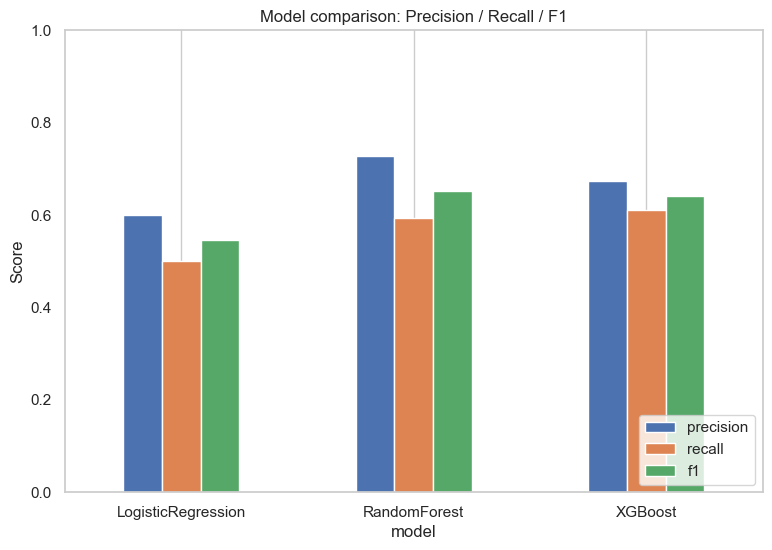

Saved metrics to model_metrics.csv


In [81]:
# ===========================
# Cell 9 — Create metrics DataFrame & bar chart
# ===========================
metrics_df = pd.DataFrame(results).set_index('model')[['precision','recall','f1','accuracy']]
display(metrics_df)

# Bar chart (precision, recall, f1)
metrics_df[['precision','recall','f1']].plot(kind='bar', figsize=(9,6))
plt.title("Model comparison: Precision / Recall / F1")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

# Save metrics to CSV
metrics_df.to_csv('model_metrics.csv')
print("Saved metrics to model_metrics.csv")


In [82]:
# Optimized Random Forest with SMOTE + RandomizedSearchCV

from imblearn.pipeline import Pipeline   # <-- imblearn Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

# Define pipeline (SMOTE + RF)
pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Parameter grid (prefix with 'rf__' because RF is inside pipeline)
param_grid = {
    "rf__n_estimators": [100, 200, 300, 500],
    "rf__max_depth": [4, 6, 8, 12, 16, None],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4, 6],
    "rf__max_features": ["sqrt", "log2"],
    "rf__class_weight": [None, "balanced"]
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,   # increase for more exhaustive search
    cv=cv,
    scoring="f1",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on training data
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV F1 Score:", random_search.best_score_)

# Best model
best_rf = random_search.best_estimator_

# Evaluate on test set
y_pred_opt = best_rf.predict(X_test)

print("\n===== Optimized Random Forest (Test Set) =====")
print(classification_report(y_test, y_pred_opt))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': 12, 'rf__class_weight': 'balanced'}
Best CV F1 Score: 0.6952286114348342

===== Optimized Random Forest (Test Set) =====
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       100
           1       0.62      0.69      0.65        54

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154



In [83]:
# ===========================
# Cell 10 — Cross-validation (5-fold) for stability (precision)
# ===========================
from sklearn.model_selection import cross_val_score

print("5-fold CV mean precision (with std):")
cv_results = {}
# for logistic use pipeline (already pipe_log)
cv_results['LogisticRegression'] = cross_val_score(pipe_log, X, y, cv=5, scoring='precision')
cv_results['RandomForest'] = cross_val_score(rf, X, y, cv=5, scoring='precision')
cv_results['XGBoost'] = cross_val_score(xgb, X, y, cv=5, scoring='precision')

for name, scores in cv_results.items():
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")


5-fold CV mean precision (with std):


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

LogisticRegression: 0.7256 ± 0.0444
RandomForest: 0.6921 ± 0.0573
XGBoost: 0.6407 ± 0.0419


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


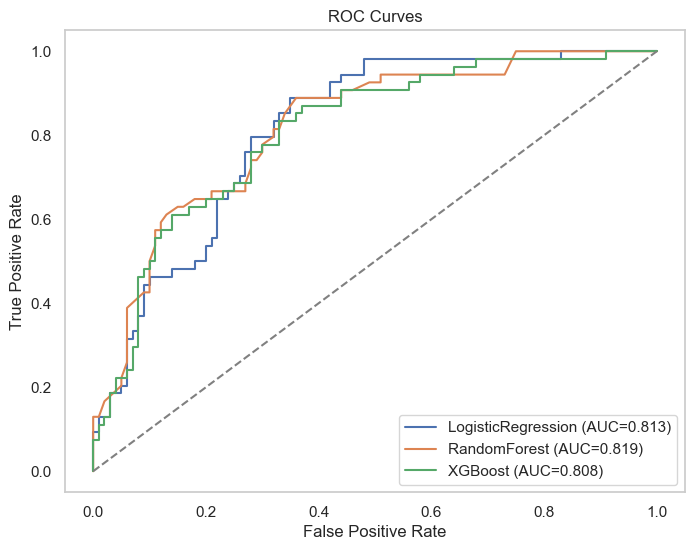

In [84]:
# ===========================
# Cell 11 — ROC curves & AUC (optional but recommended)
# ===========================
plt.figure(figsize=(8,6))
for r in results:
    name = r['model']
    proba = r['y_proba']
    if proba is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc='lower right')
plt.grid()
plt.show()


Best model by PRECISION: RandomForest


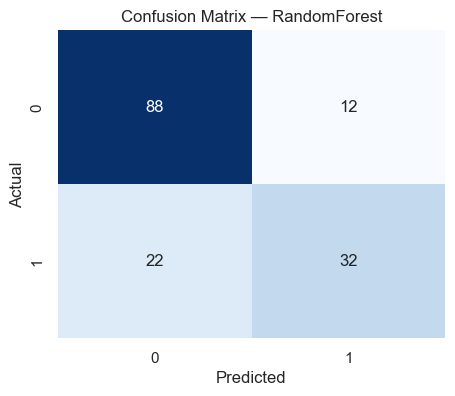

In [85]:
# ===========================
# Cell 12 — Confusion matrix for best-by-precision
# ===========================
# Determine best model by precision
best_name = metrics_df['precision'].idxmax()
best_model = models[best_name]
print("Best model by PRECISION:", best_name)

# Confusion matrix
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix — {best_name}")
plt.show()


In [86]:
import joblib
joblib.dump(rf, "best_model.pkl")


['best_model.pkl']